# Pembacaan Data

In [335]:
import cv2
import datetime
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil
import urllib.request

from skimage import img_as_ubyte
from skimage.feature import graycomatrix, graycoprops
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from google.colab.patches import cv2_imshow

In [310]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Membuat Subfolder

In [ ]:
# Menentukan path
base_path = "/content/drive/MyDrive/tugas-akhir-pcd/dataset"
paths = ["train", "valid"]
# Membuat subdirektori baru untuk data train dan val yang masing-masing berisi folder class FRESH, HALF-FRESH, dan SPOILED
classes = ["FRESH","HALF-FRESH","SPOILED"]
for i in range(len(paths)):
    for j in range(len(classes)):
        sub_folder = os.path.join(paths[i], classes[j])
        os.makedirs(os.path.join(base_path, sub_folder))

## Pengisian Gambar ke Subfolder


In [ ]:
# Mengisi gambar ke folder class yang sesuai (data train)
base_dir = "/content/drive/MyDrive/tugas-akhir-pcd/dataset_raw"
train_path = os.path.join(base_dir, "train")
"""For train."""
for filename in os.listdir(train_path):
    if filename.rfind("FRESH") == 0:
        shutil.copy(os.path.join(train_path,filename),base_path + "/train/FRESH")
    elif filename.rfind("HALF-FRESH") == 0:
        shutil.copy(os.path.join(train_path,filename),base_path + "/train/HALF-FRESH")
    elif filename.rfind("SPOILED") == 0:
        shutil.copy(os.path.join(train_path,filename),base_path + "/train/SPOILED")
    else:
        pass

In [ ]:
base_dir = "/content/drive/MyDrive/tugas-akhir-pcd/dataset_raw"
print(len(os.listdir(base_dir + "/train/")))
print(len(os.listdir(base_dir + "/valid/")))

In [ ]:
# Mengisi gambar ke folder class yang sesuai (data val)
val_path = os.path.join(base_dir, "valid")
"""For validation."""
for filename in os.listdir(val_path):
    if filename.rfind("FRESH") == 0:
        shutil.copy(os.path.join(val_path,filename),base_path + "/valid/FRESH")
    elif filename.rfind("HALF-FRESH") == 0:
        shutil.copy(os.path.join(val_path,filename),base_path + "/valid/HALF-FRESH")
    elif filename.rfind("SPOILED") == 0:
        shutil.copy(os.path.join(val_path,filename),base_path + "/valid/SPOILED")
    else:
        pass

In [336]:
# Pengecekan jumlah data
base_path = "/content/drive/MyDrive/tugas-akhir-pcd/dataset"
train_FRESH = len(os.listdir(base_path + "/train/FRESH"))
train_HALF_FRESH = len(os.listdir(base_path + "/train/HALF-FRESH"))
train_SPOILED = len(os.listdir(base_path + "/train/SPOILED"))
total_train = train_FRESH + train_HALF_FRESH + train_SPOILED

valid_FRESH = len(os.listdir(base_path + "/valid/FRESH"))
valid_HALF_FRESH = len(os.listdir(base_path + "/valid/HALF-FRESH"))
valid_SPOILED = len(os.listdir(base_path + "/valid/SPOILED"))
total_valid = valid_FRESH + valid_HALF_FRESH + valid_SPOILED

print("Training :")
print("================")
print(f"FRESH: {train_FRESH}")
print(f"HALF-FRESH: {train_HALF_FRESH}")
print(f"SPOILED: {train_SPOILED}")
print(f"Total Data: {total_train}")
print("")
print("Validation :")
print("================")
print(f"FRESH: {valid_FRESH}")
print(f"HALF-FRESH: {valid_HALF_FRESH}")
print(f"SPOILED: {valid_SPOILED}")
print(f"Total Data: {total_valid}")
print("")
print(f"Percentage Training Data: {total_train/(total_train+total_valid)*100} %")
print(f"Percentage Validation Data: {total_valid/(total_train+total_valid)*100} %")

Training :
FRESH: 675
HALF-FRESH: 630
SPOILED: 510
Total Data: 1815

Validation :
FRESH: 178
HALF-FRESH: 159
SPOILED: 114
Total Data: 451

Percentage Training Data: 80.09708737864078 %
Percentage Validation Data: 19.902912621359224 %


# Praproses Data

In [337]:
def read_image(file_path):
  # Membaca data dalam format grayscale
  image = cv2.imread(file_path, 0)  


  # Mengubah ukuran gambar menjadi 250x250 piksel
  image = cv2.resize(image, (250, 250))  


  # Normalisasi gambar menjadi 0-1
  image = image.astype(np.float32) / 255.0
  return image

# Pembuatan Model

In [338]:
# Fungsi untuk mendapatkan path ke setiap file image pada direktori
def get_list_path_file(name):
  files = []
  labels = []
  # Mendefinisikan path direktori data train dan validasi
  base_path = "/content/drive/MyDrive/tugas-akhir-pcd/dataset/"
  path_dir = os.path.join(base_path, name)
  print(path_dir)
  for class_name in os.listdir(path_dir):
    class_dir = os.path.join(path_dir, class_name)
    for file_name in os.listdir(class_dir):
      file_path = os.path.join(class_dir, file_name)
      files.append(file_path)
      labels.append(class_name)
  return files, labels

## Decision Tree

In [339]:
# Mendapatkan list path file gambar dan label kelas dari data train
train_files, train_labels = get_list_path_file("train")


# Mendapatkan list path file gambar dan label kelas dari data validasi
valid_files, valid_labels = get_list_path_file("valid")


# Membaca dan memproses gambar untuk data train
X_train = np.array([read_image(file_path) for file_path in train_files])
X_train = np.reshape(X_train, (X_train.shape[0], -1))

y_train = np.array(train_labels)


# Membaca dan memproses gambar untuk data validasi
X_valid = np.array([read_image(file_path) for file_path in valid_files])
X_valid = np.reshape(X_valid, (X_valid.shape[0], -1))

y_valid = np.array(valid_labels)


# Membuat dan melatih model Decision Tree
model = DecisionTreeClassifier(random_state=27, max_depth=9, min_samples_split=100, min_samples_leaf=25)
model.fit(X_train, y_train)


# Melakukan prediksi pada data validasi
y_pred = model.predict(X_valid)


# Menghitung akurasi model
accuracy = accuracy_score(y_pred, y_valid)
print("Akurasi model Decision Tree: ", accuracy)

/content/drive/MyDrive/tugas-akhir-pcd/dataset/train
/content/drive/MyDrive/tugas-akhir-pcd/dataset/valid
Akurasi model Decision Tree:  0.5365853658536586


In [340]:
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train_pred, y_train)
test_accuracy = accuracy_score(y_pred, y_valid)
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:    ", test_accuracy)

Training Accuracy: 0.6909090909090909
Test Accuracy:     0.5365853658536586


## Random Forest


### Model 1: Tanpa Feature Engineering

In [341]:
# Mendapatkan list path file gambar dan label kelas dari data train
train_files, train_labels = get_list_path_file("train")


# Mendapatkan list path file gambar dan label kelas dari data validasi
valid_files, valid_labels = get_list_path_file("valid")


# Membaca dan memproses gambar untuk data train
X_train = np.array([read_image(file_path) for file_path in train_files])
X_train = np.reshape(X_train, (X_train.shape[0], -1))

y_train = np.array(train_labels)


# Membaca dan memproses gambar untuk data validasi
X_valid = np.array([read_image(file_path) for file_path in valid_files])
X_valid = np.reshape(X_valid, (X_valid.shape[0], -1))

y_valid = np.array(valid_labels)


# Membuat dan melatih model Decision Tree
model = RandomForestClassifier(random_state=27, max_depth=9, n_estimators=500, min_samples_split=100, min_samples_leaf=25)
model.fit(X_train, y_train)


# Melakukan prediksi pada data validasi
y_pred = model.predict(X_valid)


# Menghitung akurasi model
accuracy = accuracy_score(y_pred, y_valid)
print("Akurasi model Random Forest: ", accuracy)

/content/drive/MyDrive/tugas-akhir-pcd/dataset/train
/content/drive/MyDrive/tugas-akhir-pcd/dataset/valid
Akurasi model Random Forest:  0.7139689578713969


In [342]:
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train_pred, y_train)
test_accuracy = accuracy_score(y_pred, y_valid)
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:    ", test_accuracy)

Training Accuracy: 0.8793388429752066
Test Accuracy:     0.7139689578713969


### Model 2: Dengan Feature Engineering GLCM

In [343]:
# Fungsi untuk ekstraksi fitur GLCM
def extract_glcm_features(image):
  # Konversi gambar menjadi tipe data unsigned integer
  image = img_as_ubyte(image)


  # Hitung matriks GLCM
  glcm = graycomatrix(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)


  # Ekstraksi fitur dari matriks GLCM
  contrast = graycoprops(glcm, 'contrast')
  contrast = contrast.astype(np.float32) / 255.0

  correlation = graycoprops(glcm, 'correlation')
  correlation = correlation.astype(np.float32) / 255.0

  homogeneity = graycoprops(glcm, 'homogeneity')
  homogeneity = homogeneity.astype(np.float32) / 255.0

  dissimilarity = graycoprops(glcm, 'dissimilarity')
  dissimilarity = dissimilarity.astype(np.float32) / 255.0

  return np.concatenate([contrast, correlation, homogeneity, dissimilarity])

In [344]:
# Mendapatkan list path file gambar dan label kelas dari data train
train_files, train_labels = get_list_path_file("train")


# Mendapatkan list path file gambar dan label kelas dari data validasi
valid_files, valid_labels = get_list_path_file("valid")


# Membaca dan memproses gambar untuk data train
X_train = np.array([read_image(file_path) for file_path in train_files])
y_train = np.array(train_labels)


# Ekstraksi fitur GLCM untuk setiap gambar dalam data train
X_train_features = np.array([extract_glcm_features(image) for image in X_train])
X_train_features = np.reshape(X_train_features, (X_train_features.shape[0], -1))


# Membaca dan memproses gambar untuk data validasi
X_valid = np.array([read_image(file_path) for file_path in valid_files])
y_valid = np.array(valid_labels)


# Ekstraksi fitur GLCM untuk setiap gambar dalam data validasi
X_valid_features = np.array([extract_glcm_features(image) for image in X_valid])
X_valid_features = np.reshape(X_valid_features, (X_valid_features.shape[0], -1))


# Membuat dan melatih model Decision Tree dengan fitur yang diekstraksi
model = RandomForestClassifier(random_state=27, max_depth=9, n_estimators=300, min_samples_split=25, min_samples_leaf=15)
model.fit(X_train_features, y_train)


# Melakukan prediksi pada data validasi
y_pred = model.predict(X_valid_features)


# Menghitung akurasi model
accuracy = accuracy_score(y_pred, y_valid)
print("Akurasi model Random Forest setelah Feature Engineering: ", accuracy)

/content/drive/MyDrive/tugas-akhir-pcd/dataset/train
/content/drive/MyDrive/tugas-akhir-pcd/dataset/valid
Akurasi model Random Forest setelah Feature Engineering:  0.7450110864745011


In [345]:
y_train_pred = model.predict(X_train_features)
train_accuracy = accuracy_score(y_train_pred, y_train)
test_accuracy = accuracy_score(y_pred, y_valid)
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:    ", test_accuracy)

Training Accuracy: 0.8258953168044078
Test Accuracy:     0.7450110864745011


# Evaluasi Model

## Confusion Matrix

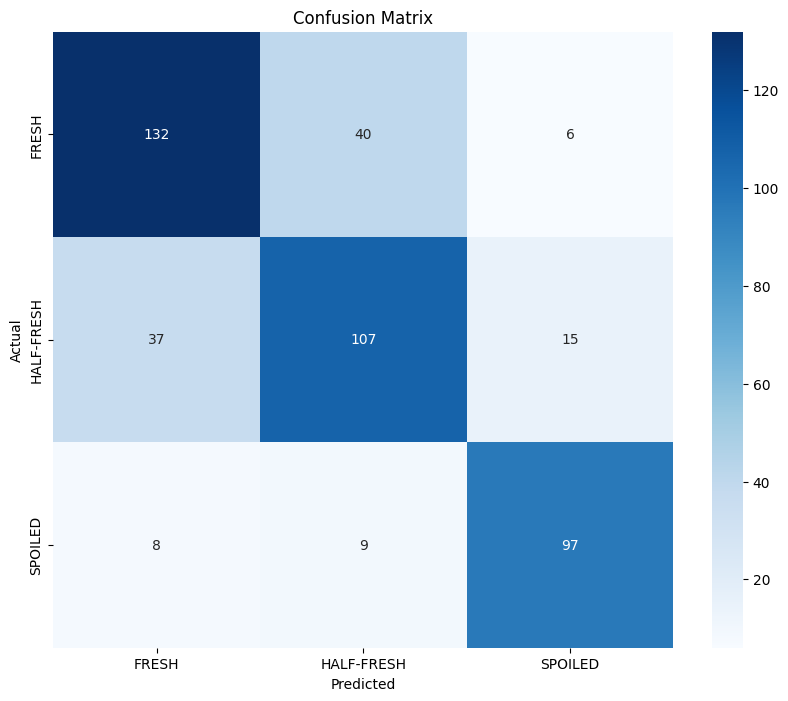

In [346]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## 0 -> FRESH, 1 -> HALF-FRESH, 2 -> SPOILED

cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['FRESH', 'HALF-FRESH', 'SPOILED'], yticklabels=['FRESH', 'HALF-FRESH', 'SPOILED'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [347]:
y_train_pred = model.predict(X_train_features)
# Mendapatkan laporan klasifikasi
report = classification_report(y_train_pred, y_train)

# Menampilkan laporan klasifikasi
print(report)

              precision    recall  f1-score   support

       FRESH       0.84      0.81      0.82       696
  HALF-FRESH       0.80      0.79      0.79       635
     SPOILED       0.85      0.89      0.87       484

    accuracy                           0.83      1815
   macro avg       0.83      0.83      0.83      1815
weighted avg       0.83      0.83      0.83      1815



In [348]:
# Mendapatkan laporan klasifikasi
report = classification_report(y_valid, y_pred)

# Menampilkan laporan klasifikasi
print(report)

              precision    recall  f1-score   support

       FRESH       0.75      0.74      0.74       178
  HALF-FRESH       0.69      0.67      0.68       159
     SPOILED       0.82      0.85      0.84       114

    accuracy                           0.75       451
   macro avg       0.75      0.76      0.75       451
weighted avg       0.74      0.75      0.74       451



## Cross-Validation

In [349]:
y_train_pred = model.predict(X_train_features)

# Mendapatkan laporan klasifikasi
accuracy = accuracy_score(y_train, y_train_pred)

# Menampilkan laporan klasifikasi
print("Training Accuracy: ", accuracy)

Training Accuracy:  0.8258953168044078


In [350]:
# Mendapatkan laporan klasifikasi
accuracy = accuracy_score(y_valid, y_pred)

# Menampilkan laporan klasifikasi
print("Test Accuracy: ", accuracy)

Test Accuracy:  0.7450110864745011


In [351]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train_features, y_train, cv=5, scoring='accuracy')
print(scores)

[0.65564738 0.57300275 0.66666667 0.51239669 0.67217631]


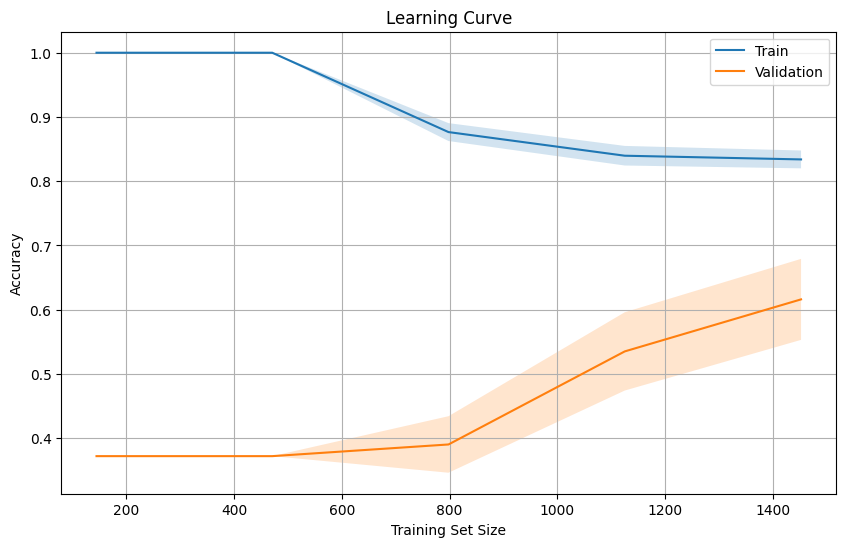

In [352]:
# Menggambar learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_train_features, y_train, cv=5, scoring='accuracy')

# Menghitung rata-rata dan standar deviasi dari skor train dan test
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Train')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, test_mean, label='Validation')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [353]:
print(train_sizes)

[ 145  471  798 1125 1452]


## Melihat Decision Tree yang terbentuk

In [354]:
dot_data = export_graphviz(model.estimators_[0], out_file=None, filled=True)
graph = graphviz.Source(dot_data)

# Tampilkan visualisasi model Decision Tree
graph.format = 'png'
graph.render('decision_tree', view=True)

'decision_tree.png'

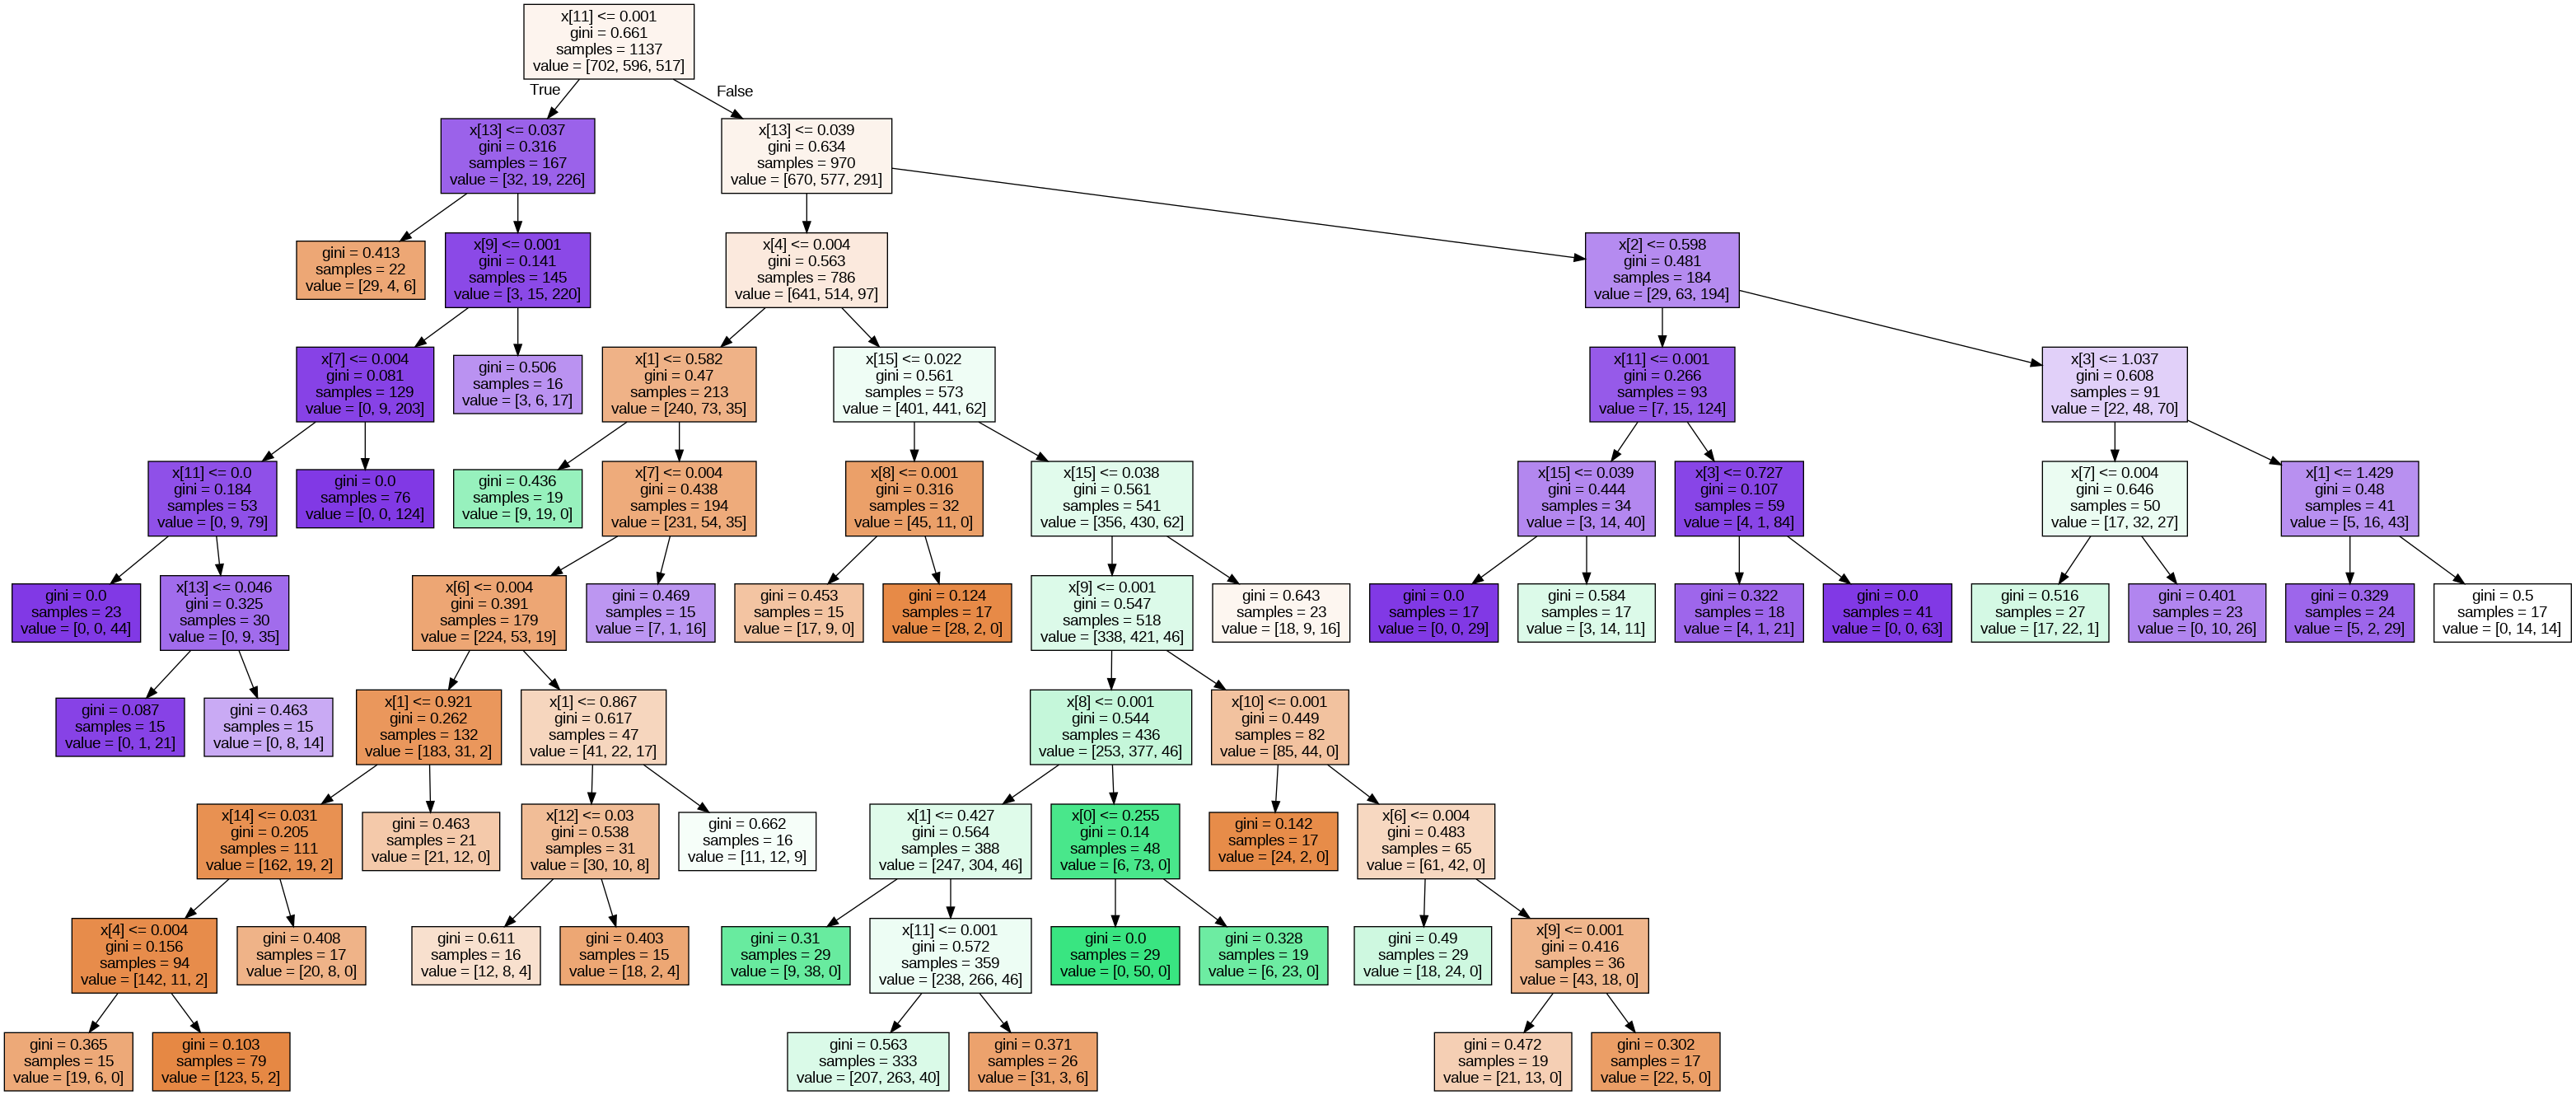

In [355]:
dt = cv2.imread("decision_tree.png")
cv2_imshow(dt)

# Melakukan Prediksi

In [356]:
# Fungsi untuk membaca gambar dari URL
def read_image_from_url(url, mode=1):
    resp = urllib.request.urlopen(url)
    image_bytes = resp.read()
    image_arr = np.asarray(bytearray(image_bytes), dtype=np.uint8)
    if mode == 0:
      image = cv2.imdecode(image_arr, cv2.IMREAD_GRAYSCALE)  # Membaca gambar dalam mode grayscale
    elif mode == 1:
      image = cv2.imdecode(image_arr, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (250, 250))  # Meresize gambar ke ukuran 150x150
    return image

Gambar ke- 1
Prediksi kelas gambar baru: ['FRESH']



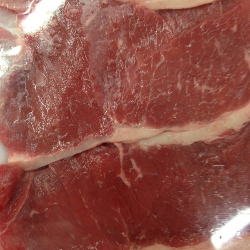


['FRESH' 'HALF-FRESH' 'SPOILED']
[[0.7262424  0.22204009 0.05171751]]


Gambar ke- 2
Prediksi kelas gambar baru: ['FRESH']



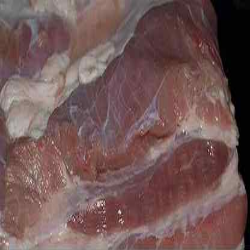


['FRESH' 'HALF-FRESH' 'SPOILED']
[[0.47122698 0.44237088 0.08640214]]


Gambar ke- 3
Prediksi kelas gambar baru: ['SPOILED']



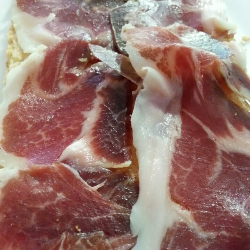


['FRESH' 'HALF-FRESH' 'SPOILED']
[[0.10138252 0.13825901 0.76035846]]


Gambar ke- 4
Prediksi kelas gambar baru: ['SPOILED']



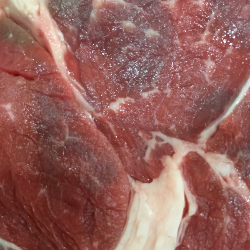


['FRESH' 'HALF-FRESH' 'SPOILED']
[[0.11216469 0.31459919 0.57323612]]


Gambar ke- 5
Prediksi kelas gambar baru: ['HALF-FRESH']



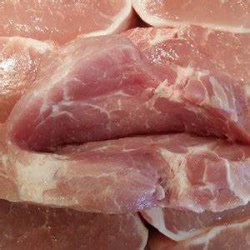


['FRESH' 'HALF-FRESH' 'SPOILED']
[[0.39585095 0.51349848 0.09065057]]


Gambar ke- 6
Prediksi kelas gambar baru: ['FRESH']



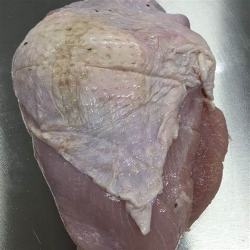


['FRESH' 'HALF-FRESH' 'SPOILED']
[[0.54454129 0.3741016  0.08135711]]


Gambar ke- 7
Prediksi kelas gambar baru: ['SPOILED']



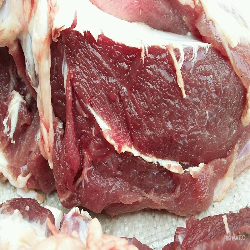


['FRESH' 'HALF-FRESH' 'SPOILED']
[[0.07196453 0.21819904 0.70983644]]


Gambar ke- 8
Prediksi kelas gambar baru: ['SPOILED']



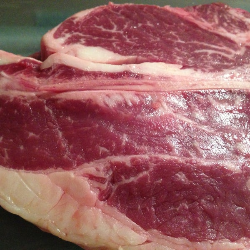


['FRESH' 'HALF-FRESH' 'SPOILED']
[[0.06140065 0.18081675 0.7577826 ]]


Gambar ke- 9
Prediksi kelas gambar baru: ['FRESH']



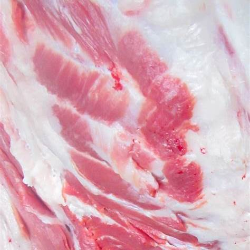


['FRESH' 'HALF-FRESH' 'SPOILED']
[[0.55112139 0.42702384 0.02185478]]


Gambar ke- 10
Prediksi kelas gambar baru: ['HALF-FRESH']



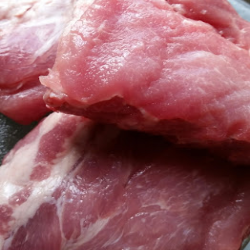


['FRESH' 'HALF-FRESH' 'SPOILED']
[[0.22669904 0.74881468 0.02448628]]


Gambar ke- 11
Prediksi kelas gambar baru: ['SPOILED']



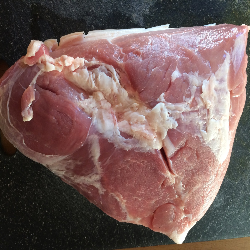


['FRESH' 'HALF-FRESH' 'SPOILED']
[[0.02097765 0.05919995 0.91982239]]




In [357]:
"""
Referensi Gambar:
(MIRIP DENGAN DATASET)
1. "https://fastly.4sqi.net/img/general/600x600/43665752_lzE6KW4jE6P4U4DL9fjaz52qgcEw8ocUcmw2_QEUrNU.jpg"
2. "https://37.img.avito.st/image/1/1.UECG37aB_Knweg6vqroie1R8-K8kevyvQx_4r_B6Dq8wePCtMH787Q.yO4OD3eYrRK3YmzlU8g6yoiKbR4K3_xw-GNfX0fWd0k"
3. "https://fastly.4sqi.net/img/general/600x600/3640854_UpsidPcJD2LSU2axzMAplnvkNOmEn2PtPamORnll8C0.jpg"
4. "https://fastly.4sqi.net/img/general/600x600/58251572_lhqKay7QupsA139u0MlVXD7EIJGSJi1KkneCNl4Pq0U.jpg"
5. "https://th.bing.com/th/id/OIP.NV9gotb4NwKlXtgNcEw6mQAAAA?pid=ImgDet&w=100&h=100&c=7&dpr=1,3"
6. "https://th.bing.com/th/id/OIP.Jp7lHxMuj3QB0hbVgFkArQHaJQ?pid=ImgDet&w=144&h=180&c=7&dpr=1,3"

(BERBEDA DENGAN DATASET)
1. "https://98.img.avito.st/1280x960/3644477498.jpg"
2. "https://fastly.4sqi.net/img/general/600x600/9216480__BXQ4-vLaKt3jMp_nFxzNZFDHFCfUx_7zeA9bKjcNNA.jpg"
3. "https://th.bing.com/th/id/OIP.l_mAfDiBoM3gXB3BeZxzHwHaJ4?pid=ImgDet&w=100&h=100&c=7&dpr=1,3"
4. "https://2.bp.blogspot.com/-lVaH2hd-Ea8/WbVx2WXorQI/AAAAAAAAj_U/mOboyk9roK4rBC0Ox5mDh1-xwPTTkYoSACLcBGAs/s320/PicsArt_09-10-10.01.06.jpg"
5. "https://www.grillsportverein.de/forum/attachments/img_3034-jpg.1813854/"
"""

list_url = [
    "https://fastly.4sqi.net/img/general/600x600/43665752_lzE6KW4jE6P4U4DL9fjaz52qgcEw8ocUcmw2_QEUrNU.jpg",
    "https://37.img.avito.st/image/1/1.UECG37aB_Knweg6vqroie1R8-K8kevyvQx_4r_B6Dq8wePCtMH787Q.yO4OD3eYrRK3YmzlU8g6yoiKbR4K3_xw-GNfX0fWd0k",
    "https://fastly.4sqi.net/img/general/600x600/3640854_UpsidPcJD2LSU2axzMAplnvkNOmEn2PtPamORnll8C0.jpg",
    "https://fastly.4sqi.net/img/general/600x600/58251572_lhqKay7QupsA139u0MlVXD7EIJGSJi1KkneCNl4Pq0U.jpg",
    "https://th.bing.com/th/id/OIP.NV9gotb4NwKlXtgNcEw6mQAAAA?pid=ImgDet&w=100&h=100&c=7&dpr=1,3",
    "https://th.bing.com/th/id/OIP.Jp7lHxMuj3QB0hbVgFkArQHaJQ?pid=ImgDet&w=144&h=180&c=7&dpr=1,3",
    "https://98.img.avito.st/1280x960/3644477498.jpg",
    "https://fastly.4sqi.net/img/general/600x600/9216480__BXQ4-vLaKt3jMp_nFxzNZFDHFCfUx_7zeA9bKjcNNA.jpg",
    "https://th.bing.com/th/id/OIP.l_mAfDiBoM3gXB3BeZxzHwHaJ4?pid=ImgDet&w=100&h=100&c=7&dpr=1,3",
    "https://2.bp.blogspot.com/-lVaH2hd-Ea8/WbVx2WXorQI/AAAAAAAAj_U/mOboyk9roK4rBC0Ox5mDh1-xwPTTkYoSACLcBGAs/s320/PicsArt_09-10-10.01.06.jpg",
    "https://www.grillsportverein.de/forum/attachments/img_3034-jpg.1813854/"
]

# Membaca gambar
pos = 1
for url in list_url:
  image = read_image_from_url(url, 0)
  image_colored = read_image_from_url(url)

  # Ekstraksi fitur pada gambar baru
  new_features = extract_glcm_features(image)

  # Reshape fitur gambar baru
  new_features = np.reshape(new_features, (1, -1))

  # Lakukan prediksi terhadap gambar baru
  prediction = model.predict(new_features)

  # Tampilkan hasil prediksi
  proba = model.predict_proba(new_features)
  print("Gambar ke-", pos)
  print("Prediksi kelas gambar baru:", prediction)
  print()
  cv2_imshow(image_colored)
  print()
  print(model.classes_)
  print(proba)
  print()
  print()
  pos += 1
